**Exploring data from Pedro**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filename = 'ExportCypherviaAPOC29Aug.xlsx'
data = pd.read_excel(filename,sheetname=None)
pd.set_option('max_rows', 5)

Here I define a function to compute the number of pairs over the years, normalised by the number of documents found in that year. This function receives as input a pair of text a - b.

In [2]:
ppy = data['Pairs per year']
ndocs = data['Number Docs per Year']
TPVal = ppy['Term Pair'].values
nall = len(ppy['Year'])
#print 'Number of entries: %d'%nel
def get_pair_evol(t3):
    # Gets the normalised number of pairs for all years
    idp1 = np.where(TPVal == t3)[0] #get all pairs
    years = ppy['Year'][idp1].values # all relevant years for the pair
    nyears = len(years)
    count_p = ppy['COUNT (d)'][idp1].values
    ids = [np.where(ndocs['YEAR'].values == x)[0] for x in years] 
    ids_list = [x[0] for x in ids]
    cc = ndocs['Count docs'].values[ids_list]
    np_list = [count_p[x]/(0.0 + cc[x]) for x in range(nyears)]
    
    
    return years, np_list #returns the years and list of normalised pairs


Here I calculate all possible combinations of pairs, including those in reverse order


In [3]:
import itertools

terms = np.unique(ppy['t1.Term'])
nterms = len(terms)
ncomb = int(nterms*(nterms-1)/2.)
print 'All pair combinations:', ncomb
comb = list(itertools.combinations(terms,2))

t3_list = ['%s - %s'%(x[0], x[1]) for x in list(comb)]
t3_list_inv = ['%s - %s'%(x[1], x[0]) for x in list(comb)]


All pair combinations: 21945


Here the code goes through the database finding each pair combination and running the function from above. To speed up the computation, this is done in parallel using `Pool` in `multiprocessing`.

In [80]:
import multiprocessing as mp

year_arr = np.sort(np.unique(ppy['Year'].values)) # It'll contain all years found in all data
nallyears = len(year_arr)

nel = ncomb
print nel

nproc = 4  # number of parallel processes
i0 = 0  
i1 = nel
npp = int((i1-i0+1.0)/(nproc+0.0)) # number of terms that each processor will deal with      

def do_pairs(ip):
    x0 = npp*ip
    x1 = ncomb-1 if ip == nproc-1 else npp*(ip+1) #the last processor absorbs possible rounding error
    np_arr = [[] for x in range(nallyears)]
    idarr  = [[] for x in range(nallyears)]
    for x in range(x0,x1):
        t3 = t3_list[x]
        year, nplist = get_pair_evol(t3)
        for iy in range(nallyears):
            year_i = year_arr[iy]
            if year_i in year:
                idnp = year.tolist().index(year_i) # index of year to find correct pair element
                np_arr[iy].append(nplist[idnp])
                idarr[iy].append(x)
      
    print 'Process %d done.'%ip
    return [np_arr, idarr] 

pool = mp.Pool(processes=nproc)
res = [pool.apply_async(do_pairs, args=(x,)) for x in range(nproc)]
np_arr_p = [p.get()[0] for p in res]
id_arr_p  = [p.get()[1] for p in res]

np_arr = [[] for x in range(nallyears)]
id_arr = [[] for x in range(nallyears)]
for i in range(nproc):
    for j in range(nallyears):
        ell = np_arr_p[i][j]
        if len(ell) != 0:
            np_arr[j].append(ell)
            id_arr[j].append(id_arr_p[i][j])

for j in range(nallyears):
    np_arr[j] = sum(np_arr[j],[])   # flattening the arrays one final time.
    id_arr[j] = sum(id_arr[j],[])




21945
Process 0 done.
Process 1 done.
Process 3 done.
Process 2 done.


The function `get_par_id` below retrieves the year array and pairs for a given pair `idnum`. 

In [115]:

def get_pair_id(idnum):
    yid = []# [[] for x in range(all_ids)]
    pid = []
    for iy in range(nallyears):
        id_iy = np.where(np.asarray(id_arr[iy]) == idnum)[0]
        if len(id_iy) ==1:
            yid.append(year_arr[iy])
            pid.append(np.asarray(np_arr[iy])[id_iy][0])
        
    return np.asarray(yid), np.asarray(pid)
        
#        plt.plot(yid,pyid[ikk][1],'k-',linewidth=.01)


Finally, things are plotted

Retrieving and plotting single pair evolution...


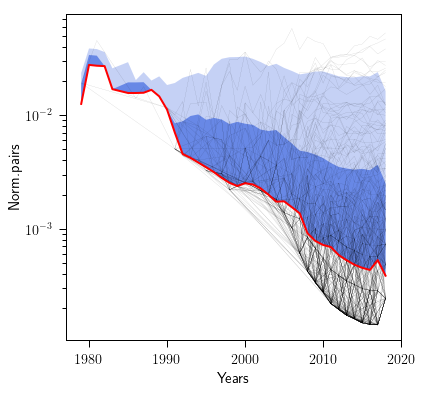

In [69]:
%matplotlib inline
from tqdm import tnrange, tqdm_notebook
plt.figure(1,figsize=(6,6))

# Retrieving each individual pair evolution -- it's a bit slow...
print 'Retrieving and plotting single pair evolution...'

# Plot 1000 random pairs
nplots = 1000
comb_perm = np.random.permutation(np.arange(ncomb))[0:nplots]

#for idd in tqdm(range(nplots)):
for idd in tqdm_notebook(range(nplots)):
    idnum = comb_perm[idd]
    yid, pyid = get_pair_id(idnum)
    plt.plot(yid,pyid,'k-',linewidth=.05)

med_pairs = np.zeros(nallyears)
perc = np.zeros([nallyears,2]) #1 and 2 sigma

    
for iy in range(nallyears):
    if len(np_arr[iy]) > 3:
        med_pairs[iy] = np.median(np_arr[iy])
        perc[iy,0]      = np.percentile(np_arr[iy], 84)
        perc[iy,1]      = np.percentile(np_arr[iy], 97.5)

nzero = np.where((med_pairs >0) & (~np.isnan(med_pairs)))[0]




#smooth curves to improve the look of the plot.
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

bp = 3
s_median = smooth(med_pairs[nzero],bp)


plt.plot(np.asarray(year_arr)[nzero], s_median,'r-',linewidth=2,label='Median')
plt.fill_between(np.asarray(year_arr)[nzero], s_median,smooth(perc[nzero,1],bp),
                 facecolor='royalblue',alpha=0.3,label=r'$1-\sigma$')
plt.fill_between(np.asarray(year_arr)[nzero], s_median,smooth(perc[nzero,0],bp),
                 facecolor='royalblue',alpha=0.7,label=r'$2-\sigma$')


plt.xlabel('Years',fontsize=15)
plt.ylabel('Norm.pairs',fontsize=15)
plt.yscale('log')
#plt.legend()

The above plot displays a few random examples of pair evolution, together with the median of all (in red). Clearly, many terms are outliers, e.g. above $1-\sigma$ (dark blue) or $2-\sigma$ (light blue) of the distribution of pair counts. The function below retrieves those outliers for a given year, above a certain percentile threshold

In [160]:
def fetch_outliers(iyear, threshold=97.9):
    # This function returns the ID of pairs that are above a given threshold (i.e. percentile). By default,
    # this corresponds to the 97.5 percentile, or ~2-sigma above the median.
    idyear = list(year_arr).index(iyear) # index of year to find outliers
    perc      = np.percentile(np_arr[idyear],threshold)
    sel = np.where(np.array(np_arr[idyear]) > perc)[0]
    return np.asarray(id_arr[idyear])[sel]
    

    

So, for example, in 2018 the following pairs are above the 97.5 percentile, $\approx 2\sigma$ outliers

In [172]:
idd = fetch_outliers(2018,threshold= 97.5)
print np.asarray(t3_list)[idd]


[u'aerobic digestion - anaerobic digestion' u'alcohol - biofuel'
 u'algae - biofuel' u'algae - biomass' u'algae - diesel' u'algae - fat'
 u'algae - gas' u'algae - oil' u'algae - waste' u'bagasse - gas'
 u'bioethanol - biofuel' u'bioethanol - biomass' u'bioethanol - ethanol'
 u'bioethanol - fermentation' u'bioethanol - gas' u'bioethanol - sugar'
 u'biofuel - biomass' u'biofuel - blend' u'biofuel - butanol'
 u'biofuel - catalysis' u'biofuel - cellulose' u'biofuel - chemicals'
 u'biofuel - combustion' u'biofuel - corn' u'biofuel - diesel'
 u'biofuel - electricity' u'biofuel - ethanol' u'biofuel - fat'
 u'biofuel - fermentation' u'biofuel - gas' u'biofuel - grass'
 u'biofuel - hydrolysis' u'biofuel - oil' u'biofuel - palm'
 u'biofuel - paper' u'biofuel - plants' u'biofuel - pyrolysis'
 u'biofuel - residues' u'biofuel - straw' u'biofuel - sugar'
 u'biofuel - sugarcane' u'biofuel - transesterification'
 u'biofuel - waste' u'biofuel - wheat' u'biofuel - wood'
 u'biofuel - yeast' u'biomass - c

Below is a function that performs the _Kolmogorov-Smirnov_ test on 2 samples, to determine how similar they are. It's a number that should reflect whether 2 samples were drawn from the same distribution or not. To do this, the KS computes the cumulative distribution of the 2 samples to compare, and then it computes the maximum separation between the two cumulative distributions.

In [175]:
from scipy import stats

def find_similar(idsrc, idlist):
    # Perform a Komogorov-Smirnov test to find pairs that have evolved similarly.
    # The arguments are:
    # idsrc: id of pair that will be compared against others
    # idlist: ids of pairs to compare against idsrc
    y_src, p_src =get_pair_id(idsrc)
    if p_src.size == 0:
        print 'src list is empty'
        return -1
    
    KS = []
    for idd in idlist:
        y_idd, p_idd = get_pair_id(idd)
        y_common, arg1, arg2 = np.intersect1d(y_src, y_idd,assume_unique=True,return_indices=True)
        if p_idd[arg2].size > 0:
            ks_idd, p_value = stats.ks_2samp(p_src[arg1], p_idd[arg2])
            KS.append(ks_idd)
        else:
            KS.append(+99.99)
    idminKS = np.argmin(np.asarray(KS))
    
    return idlist[idminKS]

And here's a test of the above code. A list of IDs is retrieved from outliers in 2016. Then, the first element is compared against all the rest, and the result is plotted.

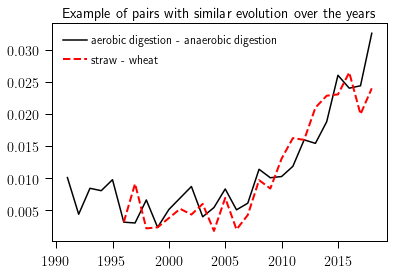

In [174]:


idt = fetch_outliers(2016,threshold= 97.5)
idsrc = idt[0]
idlist = idt[1:]
idsim= find_similar(idsrc, idlist)

y1, p1 = get_pair_id(idsrc)
y2, p2 = get_pair_id(idsim)

plt.plot(y1,p1,'k-',label=t3_list[idsrc])
plt.plot(y2,p2,'r--',linewidth=2,label=t3_list[idsim])
plt.title('Example of pairs with similar evolution over the years')
plt.legend()
    
    
    
    
    